Project 5: Vehicle Detection
by Lucas Hagel

In [8]:
import pickle, glob
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib
from sklearn.utils import shuffle
from skimage.feature import hog
from scipy.ndimage.measurements import label
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

from sklearn.cross_validation import train_test_split


from vehicle_detection_utilities import *

%matplotlib inline

non_car_data_folder = "./data/non-vehicles/Extras/*.png"
car_data_folder     = "./data/vehicles/vehicles/*.png"

# Read in cars and non-cars
car_names     = glob.glob(car_data_folder)
non_car_names = glob.glob(non_car_data_folder)

cars = []
notcars = []

for image in car_names:
    cars.append(image)
for image in non_car_names:
    notcars.append(image)

cars = shuffle(cars)
notcars = shuffle(notcars)

#have an equal number of train and test images
minlen = min(len(cars),len(notcars))
cars    = cars[:minlen]
notcars = notcars[:minlen]
'''
print("Number of car pictures", len(cars))
print("Number of non car pictures",len(notcars))
'''
def bing():
    '''
    This function makes a sound - to be used when model training/testing is complete

    This is actually crucial for a busy person, start the NN training, and then this function
    is called (and makes the sound) when training's done
    '''
    pygame_spec = importlib.util.find_spec('pygame')
    if pygame_spec is not None:
        import pygame
        pygame.mixer.init()
        soundObj = pygame.mixer.Sound('beep1.ogg')
        soundObj.play()
        time.sleep(2)
        soundObj.stop()

In [9]:
print(len(cars),len(notcars))

8792 8792


### have car and non-car filenames now!!!

### To do list
1. (CHECK) upload training images, equal numbers, 
2. Display 3 of each
3. Get a way to test training parameters
4. Check classification, maybe more data, maybe param tuning
5. Method checks different color spaces (be aware of their ranges)
6. Method that  checks parameters, the grid search thing

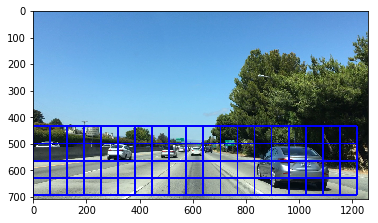

In [11]:
image = mpimg.imread('bbox-example-image.jpg')

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[435,700], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

# REPEATS!!!!!

In [12]:
#1
#RGB, HSV, LUV, HLS, YUV, YCrCb
def convert_color(img, conv='YCrCb'):
    '''
    We're reading in all colors in RGB color space 
    '''
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#2
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys',
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       block_norm= 'L2-Hys',
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
#3
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
#4                      
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    
    return window_list


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    Input: a list of bounding boxes
    Output : image with boxes drawn on it
    '''
    imcopy = np.copy(img)
    
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
def extract_features(imgs, 
                     color_space='RGB', 
                     orient=9, 
                     pix_per_cell=8, 
                     cell_per_block=2, 
                     hog_channel=0, 
                     spatial_feat=True, 
                     hist_feat=True, 
                     spatial_size=(32, 32), 
                     hist_bins=32,
                     hog_feat=True):
    features = []
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space in ['HSV', 'LUV', 'HLS', 'YUV', 'YCrCb']:
                feature_image = convert_color(image, color_space)
            else:
                feature_image = np.copy(image)
        else: feature_image = np.copy(image)      
        '''
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:            
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        '''
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    
    return features

# End of REPEATS!!!!

In [13]:
iter_num = 0
logstring = ""


search_win_params = {
'color_space' : 'YUV',
'orient' : 11,
'pix_per_cell' : 16,
'cell_per_block' : 2,
'hog_channel' : "ALL"
}

'''
for colorspace in ['YUV', 'YCrCb', 'LUV']:
    for orient in range(6,16,4):
        for pix_per_cell in range(6,16,4):
            for hog_channel in [0,1,2,'ALL']:
'''

                
t=time.time()
car_features = extract_features(cars, **search_win_params)
notcar_features = extract_features(notcars, **search_win_params)
t2 = time.time()
hogtime = round(t2-t, 2)
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Label definition
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


rand_state = 42
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
pickle.dump(X_scaler,open("scaler_long_features.p", 'wb'))

X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

logstring += "Iteration" + str(iter_num)

print(str(search_win_params['orient']),'orientations',search_win_params['pix_per_cell'],
    'pixels per cell and', search_win_params['cell_per_block'],'cells per block')
print('Feature vector length:', len(X_train[0]))

svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
accuracy = round(svc.score(X_test, y_test), 4)
accuracystr = "%.4f" % accuracy
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 2028
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')





44.61 Seconds to extract HOG features...
11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
4.03 Seconds to train SVC...
Test Accuracy of SVC =  0.9719
My SVC predicts:  [ 1.  1.  0. ...,  1.  1.  1.]
For these 2028 labels:  [ 1.  1.  0. ...,  1.  1.  1.]
0.00327 Seconds to predict 2028 labels with SVC


In [14]:
import pickle
pickle.dump(svc,open('svc_long_features.p','wb') )
